まずは必要なライブラリのインポートを行います.

In [1]:
import os
import json
from PIL import Image, ImageFont, ImageDraw
from tqdm.auto import tqdm

train_dir = './train'

### 画像データの確認

縦×横やチャンネル数を確認します. ここでは`00000.jpg`を確認します.

In [2]:
img_path = os.path.join(train_dir, '00005.jpg')
img = Image.open(img_path)
print('width, height: ', img.size)
print('mode:', img.mode)

width, height:  (176, 2366)
mode: RGB


画像はRGB形式なので, チャンネル数は3です. この画像を可視化します.

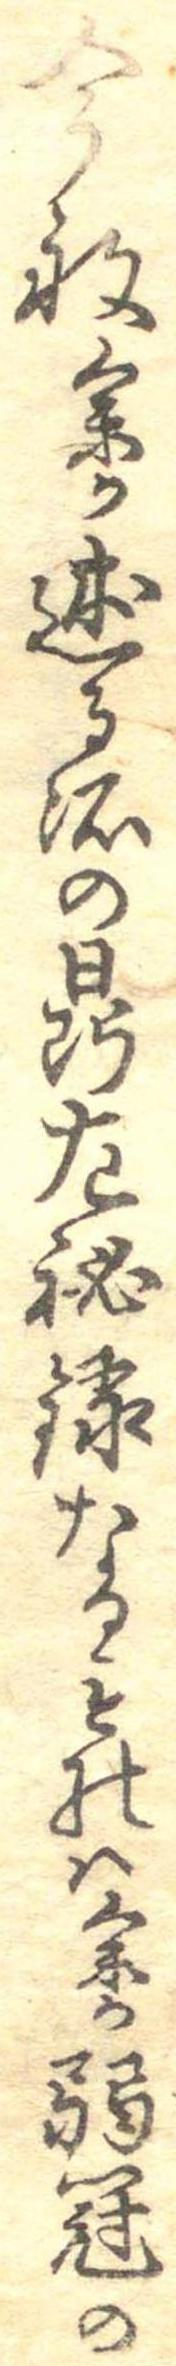

In [3]:
img

In [4]:
def describe(image_dir:str):
    count = 0
    height = 0
    width = 0
    max_height = 0
    max_width = 0
    max_aspect_ratio = 0
    for img_path in os.listdir(image_dir):
        if os.path.splitext(img_path)[-1] == '.jpg':
            img = Image.open(os.path.join(train_dir, img_path))
            count += 1
            width += img.size[0]
            height += img.size[1]
            max_width = max(img.size[0], max_width)
            max_height = max(img.size[1], max_height)
            max_aspect_ratio = max(img.size[1]/img.size[0], max_aspect_ratio)
    print('画像数: ', count)
    print('縦:', height/count)
    print('横:', width/count)
    print('縦の最大値:', max_height)
    print('横の最大値:', max_width)
    print('アスペクト比の最大値:', max_aspect_ratio)

In [5]:
describe(train_dir)

画像数:  11
縦: 1795.5454545454545
横: 204.63636363636363
縦の最大値: 2366
横の最大値: 484
アスペクト比の最大値: 15.320261437908497


縦長の画像です.

### アノテーションデータの確認

In [6]:
annotation_path = os.path.join(train_dir, '00005.json')
with open(annotation_path, encoding='utf-8') as f:
    ann = json.load(f)

In [7]:
def vis_annotation(img, ann, font_path, font_size):
    font = ImageFont.truetype(font_path, font_size)     # PILでフォントを定義
    draw = ImageDraw.Draw(img)
    for label in ann['labels']:
        draw.text(xy=(label['bbox'][0]-font_size, int((label['bbox'][1]+label['bbox'][3])/2)), text=label['label'], font=font, fill=(255,0,0))
        draw.line((label['bbox'][0], label['bbox'][1], label['bbox'][2], label['bbox'][1]), fill=(255, 0, 0), width=1)
        draw.line((label['bbox'][2], label['bbox'][1], label['bbox'][2], label['bbox'][3]), fill=(255, 0, 0), width=1)
        draw.line((label['bbox'][2], label['bbox'][3], label['bbox'][0], label['bbox'][3]), fill=(255, 0, 0), width=1)
        draw.line((label['bbox'][0], label['bbox'][3], label['bbox'][0], label['bbox'][1]), fill=(255, 0, 0), width=1)
    print(ann['text'])
    return img

今般余か述る所の鼎左秘録なるものは余か弱冠の


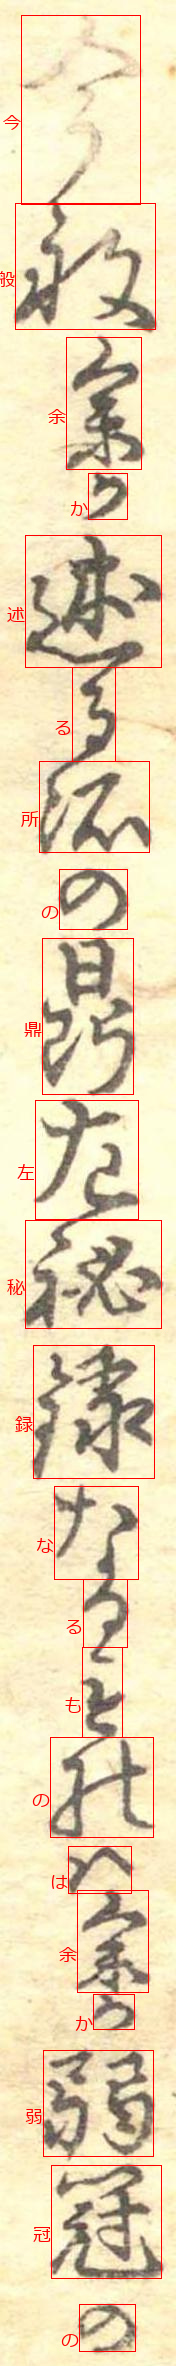

In [8]:
font_path = './meiryo.ttc'                          # フォントファイルへのパス
font_size = 18                                      # フォントサイズの指定
img = vis_annotation(img, ann, font_path, font_size)
img

In [9]:
def check_characters(img_dir:str):
    characters = {}
    for ann_path in os.listdir(img_dir):
        if os.path.splitext(ann_path)[-1] == '.json':
            with open(os.path.join(train_dir, ann_path), encoding='utf-8') as f:
                ann = json.load(f)
            for character in ann['text']:
                if character not in characters:
                    characters[character] = 1
                else:
                    characters[character] += 1
    print('文字種数:', len(characters))
    print('\n出現頻度Top10:')
    for d in sorted(characters.items(), key=lambda x:x[1], reverse=True)[:10]:
        print(' ', d[0], d[1])
    print('\n出現頻度Worst10:')
    for d in sorted(characters.items(), key=lambda x:x[1])[:10]:
        print(' ', d[0], d[1])

In [10]:
b_id = []
for ann_path in tqdm(os.listdir(train_dir)):
    if os.path.splitext(ann_path)[-1] == '.json':
        with open(os.path.join(train_dir, ann_path), encoding='utf-8') as f:
            ann = json.load(f)
            b_id.append(ann["book_id"])
import pandas as pd
b_df = pd.DataFrame(b_id)
b_df["bummy"] = 0
b_df.groupby(0).count()

  0%|          | 0/22 [00:00<?, ?it/s]

,bummy
0,
000,11


In [11]:
check_characters(train_dir)

文字種数: 94

出現頻度Top10:
  の 11
  る 7
  書 5
  な 4
  と 4
  し 4
  に 4
  録 3
  か 3
  も 3

出現頻度Worst10:
  国 1
  華 1
  山 1
  著 1
  并 1
  附 1
  帝 1
  都 1
  肆 1
  尚 1


## モデリング

### 学習用データの作成

In [12]:
import json
import shutil
from tqdm.auto import tqdm

In [13]:
def make_index(src_img_dir, book_id_list):
    print('\n'+src_img_dir)
    count = 0
    character_labels = set()
    for fname in tqdm(os.listdir(src_img_dir)):
        sname, ext = os.path.splitext(fname)
        if ext=='.json':
            with open(os.path.join(src_img_dir, fname), encoding="utf-8") as f:
                ann = json.load(f)
            if ann['book_id'] in book_id_list:
                for w in ann['text']:
                    character_labels.add(w)
                count+=1
    index2character = {i+1: s for i, s in enumerate(character_labels)}
    character2index = {v:k for k, v in index2character.items()}
    with open('./index2character.json', 'w', encoding='utf-8') as f:
        json.dump(index2character, f, ensure_ascii=False, indent=4)
    with open('./character2index.json', 'w', encoding='utf-8') as f:
        json.dump(character2index, f, ensure_ascii=False, indent=4)



def make_data(src_img_dir, dst_img_dir, book_id_list):
    count = 0
    character_labels = set()
    for fname in os.listdir(src_img_dir):
        sname, ext = os.path.splitext(fname)
        if ext=='.json':
            with open(os.path.join(src_img_dir, fname), encoding="utf-8") as f:
                ann = json.load(f)
            if ann['book_id'] in book_id_list:
                
                shutil.copy(os.path.join(src_img_dir, fname), os.path.join(dst_img_dir, fname))
                shutil.copy(os.path.join(src_img_dir, sname+'.jpg'), os.path.join(dst_img_dir, sname+'.jpg'))
                for w in ann['text']:
                    character_labels.add(w)
                count+=1
            if count%1000==0:
                print('{} samples copied to {}'.format(count, dst_img_dir))
    print('{} samples copied to {}'.format(count, dst_img_dir))
    

In [14]:
for dst_img_dir in ['./train_data','./valid_data']:
    os.makedirs(dst_img_dir, exist_ok=True)

book_id_list=[str(_).zfill(3) for _ in range(30)]
make_index(train_dir, book_id_list)

train_book_id_list=[str(_).zfill(3) for _ in range(7)]
valid_book_id_list=[str(_).zfill(3) for _ in range(7,10)]
make_data(train_dir, './train_data', train_book_id_list)
make_data(train_dir, './valid_data', valid_book_id_list)


./train


  0%|          | 0/22 [00:00<?, ?it/s]

11 samples copied to ./train_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data
0 samples copied to ./valid_data


画像の縦と横の長さなどの平均や最大値を見てみます.

In [15]:
describe(dst_img_dir)

画像数:  4
縦: 2340.5
横: 160.25
縦の最大値: 2348
横の最大値: 172
アスペクト比の最大値: 15.320261437908497


### 画像の読み込みと前処理を行うインスタンスの作成

In [16]:
import torch
import json
import os
from PIL import Image
from glob import glob

In [17]:
class KuzushijiDataset(torch.utils.data.Dataset): # type: ignore
    def __init__(self, root, character2index, transforms, on_memory=False):
        self.root = root
        self.character2index = character2index
        self.transforms = transforms
        self.on_memory = on_memory
        if on_memory:
            self.imgs = [Image.open(img_path) for img_path in sorted(glob(os.path.join(root, '*.jpg')))]
            self.annotations = []
            for ann_path in sorted(glob(os.path.join(root, '*.json'))):
                with open(ann_path, encoding='utf-8') as f:
                    self.annotations.append(json.load(f))
        else:
            self.imgs = sorted(glob(os.path.join(root, '*.jpg')))
            self.annotations = sorted(glob(os.path.join(root, '*.json')))

    def __getitem__(self, idx):
        if self.on_memory:
            img = self.imgs[idx]
            ann = self.annotations[idx]
        else:
            img = Image.open(self.imgs[idx])
            with open(self.annotations[idx], encoding='utf-8') as f:
                ann = json.load(f)

        labels = torch.as_tensor([self.character2index[character] for character in ann['text']], dtype=torch.int32)


        if self.transforms is not None:
            img = self.transforms(img)

        return img, labels

    def __len__(self):
        return len(self.imgs)

In [18]:
from torch import nn, Tensor
from torchvision.transforms import functional as F, transforms as T


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        
        return image


class Align():
    def __init__(self, target_width, max_target_height):
        self.target_width = target_width
        self.max_target_height = max_target_height


    def __call__(self, image:Image.Image):
        w, h = image.size
        s = self.target_width/w
        target_height = int(s*h)
        image = image.resize((self.target_width, target_height))
        img = Image.new(mode='RGB', size=(self.target_width, self.max_target_height), color=(255,255,255))
        img.paste(im=image)
        return img


class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(
        self, image: Tensor
    ) -> Tensor:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            #dig = random.randint(-1, 1)
            #image = F.rotate(image, dig)
        return image


class PILToTensor(nn.Module):
    def forward(
        self, image: Tensor
    ) -> Tensor:
        image = F.pil_to_tensor(image)
        return image


class ConvertImageDtype(nn.Module):
    def __init__(self, dtype: torch.dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(
        self, image: Tensor
    ) -> Tensor:
        image = F.convert_image_dtype(image, self.dtype)
        return image


def get_transform(train, target_width, max_target_height):
    transforms = []
    transforms.append(Align(target_width, max_target_height))
    transforms.append(PILToTensor())
    transforms.append(ConvertImageDtype(torch.float))
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

In [19]:
# on_memory=Trueにした場合, このセルを2回以上実行するとエラーになるので, 2回以上実行する際は事前に`kuzushiji_dataset`を削除(`del kuzushiji_dataset`)してください.
with open('./character2index.json', encoding='utf-8') as f:
    character2index = json.load(f)
target_width = 128
max_target_height = 3840
train_dataset = KuzushijiDataset('./train_data', character2index, get_transform(train=True, target_width=target_width, max_target_height=max_target_height))
valid_dataset = KuzushijiDataset('./valid_data', character2index, get_transform(train=True, target_width=target_width, max_target_height=max_target_height))

In [20]:
datasets = {"train":train_dataset,
          "valid":valid_dataset}

In [21]:
with open('./index2character.json', encoding='utf-8') as f:
    index2character = json.load(f)
img, labels = datasets["train"][10]

print('image:')
print(' ', type(img), img.shape)
print('labels:')
print(' ', type(labels), labels.shape)
for l in labels:
    print(int(l), index2character[str(int(l))])

image:
  <class 'torch.Tensor'> torch.Size([3, 3840, 128])
labels:
  <class 'torch.Tensor'> torch.Size([21])
85 松
24 の
14 み
75 と
93 り
29 あ
59 る
39 ひ
7 は
16 小
51 池
89 に
70 生
10 し
52 た
59 る
90 蓮
24 の
2 根
76 な
75 と


### 深層学習モデルの構築

In [22]:
import timm

In [23]:
class KuzushijiModel(torch.nn.Module):
    def __init__(self, model_name, num_classes, input_length = 80, d_model=512, pretrained=True):
        super(KuzushijiModel, self).__init__()
        self.backbone = timm.create_model(model_name=model_name, pretrained=pretrained)
        self.apool = torch.nn.AdaptiveAvgPool2d((input_length, 1))
        self.linear = torch.nn.Linear(self.backbone.num_features, d_model)

        self.last_linear = torch.nn.Linear(d_model, num_classes)


    def forward(self, x):
        x = torch.relu(self.backbone.forward_features(x))
        x = self.apool(x)
        x = x.squeeze(3)
        x = x.permute(2, 0, 1)
        x = torch.relu(self.linear(x))
        x = self.last_linear(x)

        return x

In [24]:
input_length = 128
num_classes = 3056
#model = KuzushijiModel(model_name='tf_efficientnet_b0', num_classes=num_classes, input_length=input_length)
model = KuzushijiModel(model_name='tf_efficientnetv2_m_in21k', num_classes=num_classes, input_length=input_length)


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnetv2_m_in21k to current tf_efficientnetv2_m.in21k.
  model = create_fn(


In [25]:
x=torch.rand((1,3,3840, 128))
y=model(x)
print(y.shape)
print(y[0])

torch.Size([128, 1, 3056])
tensor([[ 0.4485, -0.0620, -0.1396,  ..., -0.2296, -0.1148,  0.1234]],
       grad_fn=<SelectBackward0>)


### 深層学習モデルの学習

次に作成した学習データ(`kuzushiji_dataset`)を用いて構築したモデル(`model`)を学習します.

In [26]:
import math
import sys

def train_one_epoch(model, optimizer, train_data_loader, valid_data_loader, ctc_loss, input_length, device, print_freq):
    model.train()

    size = len(train_data_loader)
    for i, (images, targets) in tqdm(enumerate(train_data_loader)):
        images = torch.stack(images).to(device)
        input_lengths = torch.full(size=(len(images),), fill_value=input_length, dtype=torch.long)
        max_target_length = 0
        target_lengths = []
        for t in targets:
            target_lengths.append(len(t))
            max_target_length = max(t.shape[0], max_target_length)
        target_lengths = torch.tensor(target_lengths)
        targets_filled = []
        for t in targets:
            targets_filled.append(torch.cat((t, torch.zeros(max_target_length-len(t), dtype=torch.int32))))
        targets_filled = torch.stack(targets_filled).to(device)
        y = model(images)
        log_softmax = y.log_softmax(2)
        optimizer.zero_grad()
        loss = ctc_loss(log_softmax, targets_filled, input_lengths, target_lengths)
        if (i+1) %print_freq==0:
            print('[{}/{}] Loss: {}'.format(i+1, size, round(float(loss),3)))
        if not math.isfinite(float(loss)):
            print(f"Loss is {float(loss)}, stopping training")
            print(float(loss))
            sys.exit(1)

        loss.backward()
        optimizer.step()
        
    # Test(val) loop ----------------------------
    model.eval()  # 学習モードをオフ
    test_batch_loss = []
    with torch.no_grad():  # 勾配を計算なし
        for images, targets in tqdm(valid_data_loader):
        
            images = torch.stack(images).to(device)
            input_lengths = torch.full(size=(len(images),), fill_value=input_length, dtype=torch.long)
            max_target_length = 0
            target_lengths = []
        
            for t in targets:
                target_lengths.append(len(t))
                max_target_length = max(t.shape[0], max_target_length)
            target_lengths = torch.tensor(target_lengths)
            targets_filled = []
            for t in targets:
                targets_filled.append(torch.cat((t, torch.zeros(max_target_length-len(t), dtype=torch.int32))))
            targets_filled = torch.stack(targets_filled).to(device)
            y = model(images)
            log_softmax = y.log_softmax(2)
            loss = ctc_loss(log_softmax, targets_filled, input_lengths, target_lengths)


def collate_fn(batch):
    return tuple(zip(*batch))

In [27]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# define training and validation data loaders
batch_size=2
train_data_loader = torch.utils.data.DataLoader( # type: ignore
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_fn)

valid_data_loader = torch.utils.data.DataLoader( # type: ignore
    valid_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_fn)

# move model to the right device
model.to(device)

# construct an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

# let's train it for 3 epochs
num_epochs = 50
ctc_loss = torch.nn.CTCLoss()

for epoch in range(num_epochs):
    print('Epoch {}:'.format(epoch+1))
    # train for one epoch, printing every 200 iterations
    train_one_epoch(model, optimizer, train_data_loader, valid_data_loader, ctc_loss, input_length, device, print_freq=200)


Epoch 1:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50:


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

モデルは`CTC(Connectionist Temporal Classification)Loss`により学習を行います. これは時系列データに対してラベルの系列をフィットさせるときなどに用いられる損失関数です. 今回は画像データにおいて(縦書きなので)縦方向(上から下)に時間が走っているとみなしてラベル(文字種)を割り当てる問題とみています.[仕様](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html)

### 深層学習モデルによる予測

次に学習したモデルにより予測を行い, その結果と正解ラベルを確認してみます.

In [28]:
def merge_duplicates(input_str):
    result = []
    current_char = None

    for char in input_str:
        if char != current_char:
            result.append(char)
            current_char = char

    return ''.join(result)


正解: 今般余か述る所の鼎左秘録なるものは余か弱冠の
推論: 今般か鼎左秘録か弱の


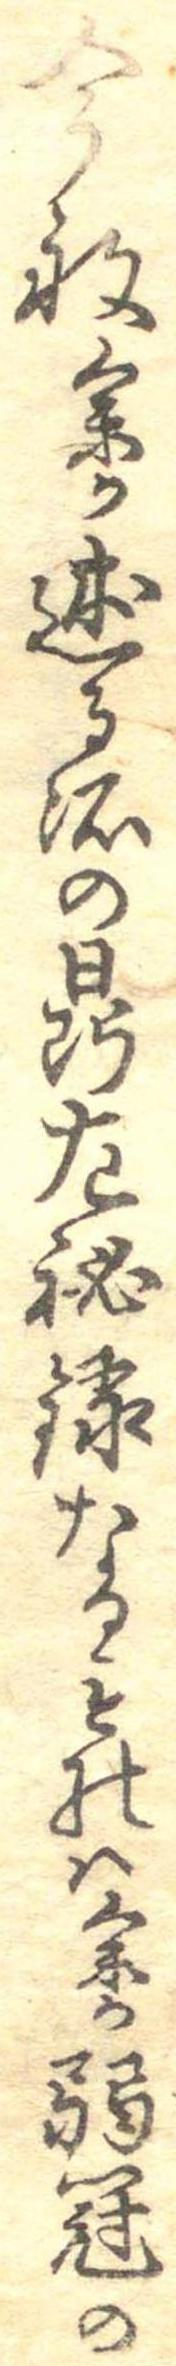

In [29]:
sample_id = '00005'
# 予測
img_path = os.path.join(train_dir, '{}.jpg'.format(sample_id))
image = Image.open(img_path)
img = get_transform(train=False, target_width=target_width, max_target_height=max_target_height)(image)
img = img.unsqueeze(0) # type: ignore
model.to(device)
model.eval()
with torch.no_grad():
    prediction = model(img.to(device)) # type: ignore
_, output_index = prediction.max(2)
pred = output_index.squeeze(1).cpu().detach().numpy()

with open('./index2character.json', encoding='utf-8') as f:
    index2character = json.load(f)
txt = ''
for p in pred:
    if p != 0:
        txt+=index2character[str(p)]

# 正解ラベル
annotation_path = os.path.join(train_dir, '{}.json'.format(sample_id))
with open(annotation_path, encoding='utf-8') as f:
    ann = json.load(f)
ans = ann['text']
txt = merge_duplicates(txt)

print('正解: {}'.format(ans))
print('推論: {}'.format(txt))
image